In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

In [2]:
train_df = pd.read_csv('/home/howt51/work/vscode_micromamba/kaggle/data/playground-series-s3e18/train.csv')
test_df = pd.read_csv('/home/howt51/work/vscode_micromamba/kaggle/data/playground-series-s3e18/test.csv')

In [3]:
def process(df):
    df['MolWt'] = df['HeavyAtomMolWt'] + df['ExactMolWt']
    df['NumRotatableBonds'] = df['Chi3v'] + df['Chi4n']
    df['NumAromaticRings'] = df['BertzCT'] - df['Chi1']
    if 'EC3' in df.columns:
        df.drop(['EC3', 'EC4', 'EC5', 'EC6'], axis=1,inplace=True)
    # df.drop(['fr_COO2', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'], axis=1,inplace=True)
    return df
train_df = process(train_df)
test_df = process(test_df)

In [4]:
tmp = train_df.copy()
X_test = test_df.copy()

y1 = tmp['EC1']
y2 = tmp['EC2']
X = tmp.drop(['EC1', 'EC2'], axis=1)

In [5]:
assert set(X.columns).symmetric_difference(set(X_test.columns)) == set()

In [6]:
data1 = pd.concat([X,y1], axis=1).rename({'EC1':'target'}, axis=1)
data2 = pd.concat([X,y2], axis=1).rename({'EC2':'target'}, axis=1)

In [7]:
def pycaret_classification(data, target:str='target', model_list:list=['lightgbm','rf'], n_model_select:int=2): #,'lr','svm','gbc','catboost','lda'
    from pycaret.classification import ClassificationExperiment
    assert len(model_list) >= n_model_select
    setup_dict = {
        'fold_strategy':'kfold',
        'fold':5,
        'feature_selection':True,
        'feature_selection_method':'sequential',
        'n_features_to_select':0.7,
        'remove_outliers':True,
        'outliers_method':'iforest',
        'outliers_threshold':0.05
    }
    # init setup
    setup = ClassificationExperiment()
    setup.setup(data, target = target, session_id = 123, **setup_dict, use_gpu = False)
    setup.add_metric('apc', 'APC', sklearn.metrics.average_precision_score, target = 'pred_proba')

    # model training and selection
    best = setup.compare_models(n_select = n_model_select, include=model_list, sort = 'AUC')#sort='RMSLE'
    if n_model_select== 1:
        best_tuned = setup.tune_model(best, search_library="optuna", n_iter=30)
        return best_tuned_compare, setup
    else:
        best_tuned = [
            setup.tune_model(x, 
                    search_library="optuna",
                    n_iter=30) for x in best]

    # comparing tuned model
    best_tuned_compare = setup.compare_models(include = best_tuned, sort = 'AUC') #sort='RMSLE'
    return best_tuned_compare, setup

In [8]:
s1, s1_setup = pycaret_classification(data1, n_model_select=1)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(14838, 36)"
4,Transformed data shape,"(14318, 25)"
5,Transformed train set shape,"(9866, 25)"
6,Transformed test set shape,"(4452, 25)"
7,Numeric features,35
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6979,0.6864,0.8621,0.7329,0.7921,0.2527,0.2645,0.7871,0.4500
rf,Random Forest Classifier,0.6936,0.6816,0.8600,0.7297,0.7893,0.2413,0.2529,0.7831,0.4320


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.7069,0.7003,0.8663,0.7476,0.8026,0.2457,0.2561,0.8137
1,0.6880,0.6881,0.8882,0.7123,0.7906,0.2072,0.2278,0.7983
2,0.7063,0.6973,0.8855,0.7349,0.8032,0.2437,0.2609,0.8056
3,0.7058,0.7032,0.8973,0.7202,0.7991,0.2739,0.2982,0.7870
4,0.7044,0.6922,0.8904,0.7243,0.7988,0.2632,0.2842,0.7840
Mean,0.7023,0.6962,0.8856,0.7279,0.7989,0.2467,0.2654,0.7977
Std,0.0072,0.0054,0.0104,0.0123,0.0045,0.0227,0.0243,0.0111


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-07-11 21:14:17,460] Searching the best hyperparameters using 10386 samples...


[LightGBM] [Warning] bagging_fraction is set=0.5494163024710176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5494163024710176
[LightGBM] [Warning] feature_fraction is set=0.8282674079427135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8282674079427135
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5443111384960451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5443111384960451
[LightGBM] [Warning] feature_fraction is set=0.7078395860444378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7078395860444378
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4176467457273603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4176467457273603
[LightGBM] [Warning] feature_fracti

[I 2023-07-11 21:18:19,083] Finished hyperparemeter search!


TypeError: 'LGBMClassifier' object is not iterable

In [ ]:
s1, s1_setup = pycaret_classification(data1, n_model_select=2)

In [ ]:
s1_setup.get_config('dataset_transformed')

,BertzCT,Chi1n,Chi1v,Chi2v,Chi4n,EState_VSA2,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,HallKierAlpha,...,PEOE_VSA8,SMR_VSA10,SMR_VSA5,VSA_EState9,fr_COO,fr_COO2,MolWt,NumRotatableBonds,NumAromaticRings,target
8745,1266.094849,10.783470,13.789032,10.811769,3.408511,11.984273,584.263489,1.000000,1.741935,-1.87,...,18.181116,40.986767,69.410019,81.137619,0.0,0.0,1132.648438,11.428585,1249.068604,0
120,1459.725952,13.965436,13.965436,11.335625,3.562010,35.644482,613.008301,1.352941,1.977391,-2.97,...,35.644482,35.629456,68.590248,129.762970,0.0,0.0,1137.701294,11.386586,1442.127319,1
14220,277.172791,4.299605,5.829902,4.485235,1.289775,0.000000,260.029724,1.062500,1.625000,-0.09,...,0.000000,7.822697,24.415865,44.415588,0.0,0.0,507.060730,3.869287,270.063080,0
12093,29.019550,1.774215,1.774215,1.127305,0.000000,0.000000,89.047676,1.166667,1.666667,-0.04,...,0.000000,0.000000,6.923737,23.333334,0.0,0.0,171.085678,0.368487,26.749495,1
13439,405.799133,4.299605,4.299605,4.573989,1.920817,0.000000,206.056458,1.250000,2.266667,-0.79,...,6.923737,5.969306,24.415865,36.666668,1.0,1.0,402.145477,4.491924,398.562775,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636,257.537964,2.384290,2.384290,1.477829,0.542523,0.000000,148.037170,1.545455,2.272727,-1.68,...,0.000000,6.155365,0.000000,28.500000,0.0,0.0,288.087158,1.444864,252.590683,1
14147,1420.467407,14.040529,16.544817,13.393444,4.431173,16.981741,562.257996,1.076923,1.750000,-1.34,...,0.000000,35.629456,74.377365,99.412209,0.0,0.0,1090.694946,12.795764,1402.228027,1
576,427.639801,5.138524,8.574688,6.233151,1.125268,6.420822,299.152130,1.312500,1.812500,-0.82,...,18.684032,32.265846,26.813053,31.374731,0.0,0.0,576.305115,5.012088,418.887573,1
5181,279.702087,4.546610,4.546610,3.479310,0.930007,0.000000,196.995499,0.583333,0.916667,-0.24,...,0.000000,0.000000,30.705893,46.993008,0.0,0.0,382.015503,2.797066,273.216827,1


In [ ]:
# s1_setup.get_config('pipeline')

In [ ]:
# prep_pipe = s1.get_config('pipeline') 
# prep_pipe.transform(data)
# prep_pipe

In [9]:

# init setup
from pycaret.classification import ClassificationExperiment
import sklearn
s = ClassificationExperiment()
s.setup(data2, target = 'target', session_id = 123, use_gpu = False)

s.add_metric('apc', 'APC', sklearn.metrics.average_precision_score, target = 'pred_proba')

# model training and selection
best = s.compare_models()

# evaluate trained model
s.evaluate_model(best)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(14838, 36)"
4,Transformed data shape,"(14838, 36)"
5,Transformed train set shape,"(10386, 36)"
6,Transformed test set shape,"(4452, 36)"
7,Numeric features,35
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
ridge,Ridge Classifier,0.7991,0.0000,0.9999,0.7991,0.8883,0.0013,0.0108,0.0000,0.0420
dummy,Dummy Classifier,0.7990,0.5000,1.0000,0.7990,0.8882,0.0000,0.0000,0.7990,0.0450
gbc,Gradient Boosting Classifier,0.7984,0.5793,0.9981,0.7994,0.8878,0.0045,0.0229,0.8420,0.0370
catboost,CatBoost Classifier,0.7982,0.5619,0.9987,0.7990,0.8877,0.0002,0.0012,0.8371,7.4750
lda,Linear Discriminant Analysis,0.7981,0.5707,0.9987,0.7989,0.8877,-0.0006,-0.0045,0.8321,0.0430
ada,Ada Boost Classifier,0.7979,0.5751,0.9973,0.7994,0.8875,0.0041,0.0142,0.8359,0.0360
lr,Logistic Regression,0.7976,0.5470,0.9975,0.7991,0.8873,0.0013,0.0016,0.8260,0.2280
et,Extra Trees Classifier,0.7973,0.5636,0.9946,0.8003,0.8869,0.0125,0.0358,0.8358,0.1520
rf,Random Forest Classifier,0.7970,0.5625,0.9963,0.7992,0.8869,0.0024,0.0101,0.8340,0.0740
lightgbm,Light Gradient Boosting Machine,0.7956,0.5665,0.9935,0.7994,0.8859,0.0040,0.0110,0.8348,0.0510


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [19]:
import logging
import sklearn
import matplotlib.pyplot as plt

def log_binary_classification_metrics(y_true, y_pred):
    """
    Log all relevant metrics for binary classification.

    Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

    Returns:
    A dictionary of metrics.
    """

    metrics = {}
    metrics["accuracy"] = sklearn.metrics.accuracy_score(y_true, y_pred)
    metrics["precision"] = sklearn.metrics.precision_score(y_true, y_pred)
    metrics["recall"] = sklearn.metrics.recall_score(y_true, y_pred)
    metrics["f1_score"] = sklearn.metrics.f1_score(y_true, y_pred)
    metrics["confusion_matrix"] = sklearn.metrics.confusion_matrix(y_true, y_pred)
    metrics["average_precision_score"] = sklearn.metrics.average_precision_score(y_true, y_pred)
    metrics["roc_auc_score"] = sklearn.metrics.roc_auc_score(y_true, y_pred)

    logging.info("Binary classification metrics:")
    for metric, value in metrics.items():
        logging.info("  %s: %s", metric, value)

    return metrics


def log_classification_report_metrics(y_true, y_pred, output_format:str='dict'):
    """Log all metrics from classification_report of sklearn.

    Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.
    output_format: ['dict','pandas']

    Returns:
    A dictionary of metrics.
    """
    report = sklearn.metrics.classification_report(y_true, y_pred, output_dict=True)
    if output_format == 'dict':
        return report
    elif output_format == 'pandas':
        report_df = pd.DataFrame(report).T
        report_df.index.name = "Class"
        report_df.columns = ["Precision", "Recall", "F1-Score", "Support"]
        return report_df

def log_binary_predictions_display_plots(model, X, y):
    """plot detetion error trade off, roc and apc with sklearn.

    Args:
        y_true: The ground truth labels.
        y_pred: The predicted labels.

    Returns:
        A dictionary of plots.
        """
    
    roc_plot = sklearn.metrics.RocCurveDisplay.from_estimator(model, X, y)
    det_plot = sklearn.metrics.DetCurveDisplay.from_estimator(model, X, y)
    pr_plot = sklearn.metrics.PrecisionRecallDisplay.from_estimator(model, X, y)
    
    return {'roc':roc_plot, 'det':det_plot, 'pr':pr_plot}

In [20]:
log_binary_classification_metrics(y1, s1.predict(X))

{'accuracy': 0.7130341016309476,
 'precision': 0.7371956339210747,
 'recall': 0.8861526039563988,
 'f1_score': 0.8048400403336694,
 'confusion_matrix': array([[1800, 3130],
        [1128, 8780]]),
 'average_precision_score': 0.7292888577170487,
 'roc_auc_score': 0.6256320829112623}

{'roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f23945e3ca0>,
 'det': <sklearn.metrics._plot.det_curve.DetCurveDisplay at 0x7f23943c8850>,
 'pr': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x7f23943c8550>}

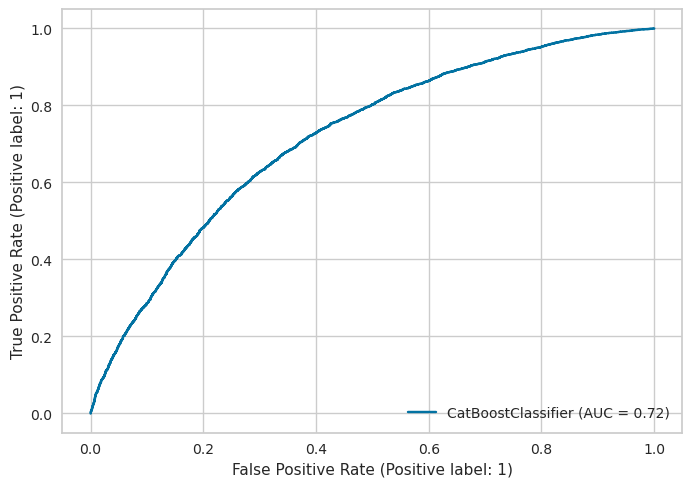

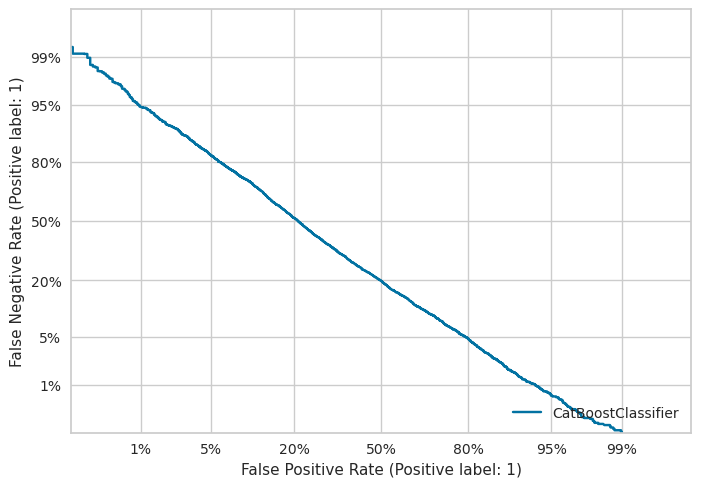

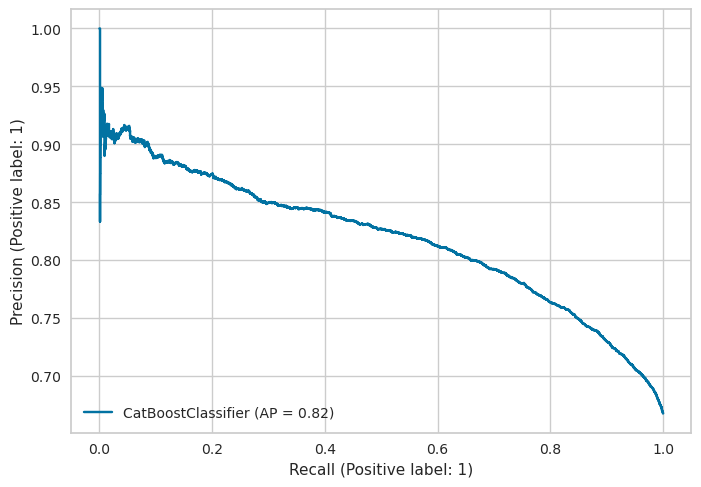

In [21]:
log_binary_predictions_display_plots(s1, X, y1)